In [1]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
initializers = tf.keras.initializers

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

from data_generator import generator
from encoding.layers import IntegerBaseEncoder, FloatBaseEncoder

c:\Users\sonng\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
seed = 123
tf.random.set_seed(seed)
gen = generator.DataGenerator(mean=12, std=3, is_int=True, noise=True, dist='lognormal')
x, y = gen.generate(n_features=1, n_samples=100)

x = np.ravel(x)
order = np.argsort(x).reshape(-1, 1)
x, y = x[order], y[order]
# x_exp = np.power(2, x)
# y_exp = np.power(2, y)
# x_log = np.log(x)
# y_log = np.log(y)

In [10]:
standard = lambda x:(x - x.mean())/x.std()

In [4]:
class _MLPBlock(keras.layers.Layer):
    def __init__(self, width, droprate=0, regularization=keras.regularizers.L1L2(0), **kwargs):
        super(_MLPBlock, self).__init__()
        self.dense = layers.Dense(width, 
                                  kernel_initializer=initializers.RandomNormal(seed=seed),
                                  kernel_regularizer=regularization, **kwargs)
#         self.activation = layers.ReLU()
#         self.drop = layers.Dropout(droprate)
#         self.bn = layers.BatchNormalization()
        
    def call(self, inputs, **kwargs):
        x = self.dense(inputs)
#         x = self.activation(x)
#         x = self.drop(x)
#         x = self.bn(x)
        return x

# implement policy network
class MLP(keras.Model):
    def __init__(self, input_dim, output_dim, hidden_dim=64, depth=1, **kwargs):
        super().__init__()
        self.depth = depth
        self.hidden_0 = _MLPBlock(hidden_dim, input_shape=(input_dim,), **kwargs)

        for i in range(1, depth):
            setattr(self, f'hidden_{i}', _MLPBlock(hidden_dim))
        self.out = _MLPBlock(output_dim)

    
    def call(self, inputs):
        x = inputs
        for i in range(self.depth):
            x = getattr(self, f'hidden_{i}')(x)
        x = self.out(x)
        return x

4/4 [==============================] - 0s 2ms/step
intact 115783579613230.0
4/4 [==============================] - 0s 2ms/step
standardization 101845968134586.77
4/4 [==============================] - 0s 2ms/step
binary explosion 100471927364166.78
4/4 [==============================] - 0s 2ms/step
higher dimensionality 108356145113433.08


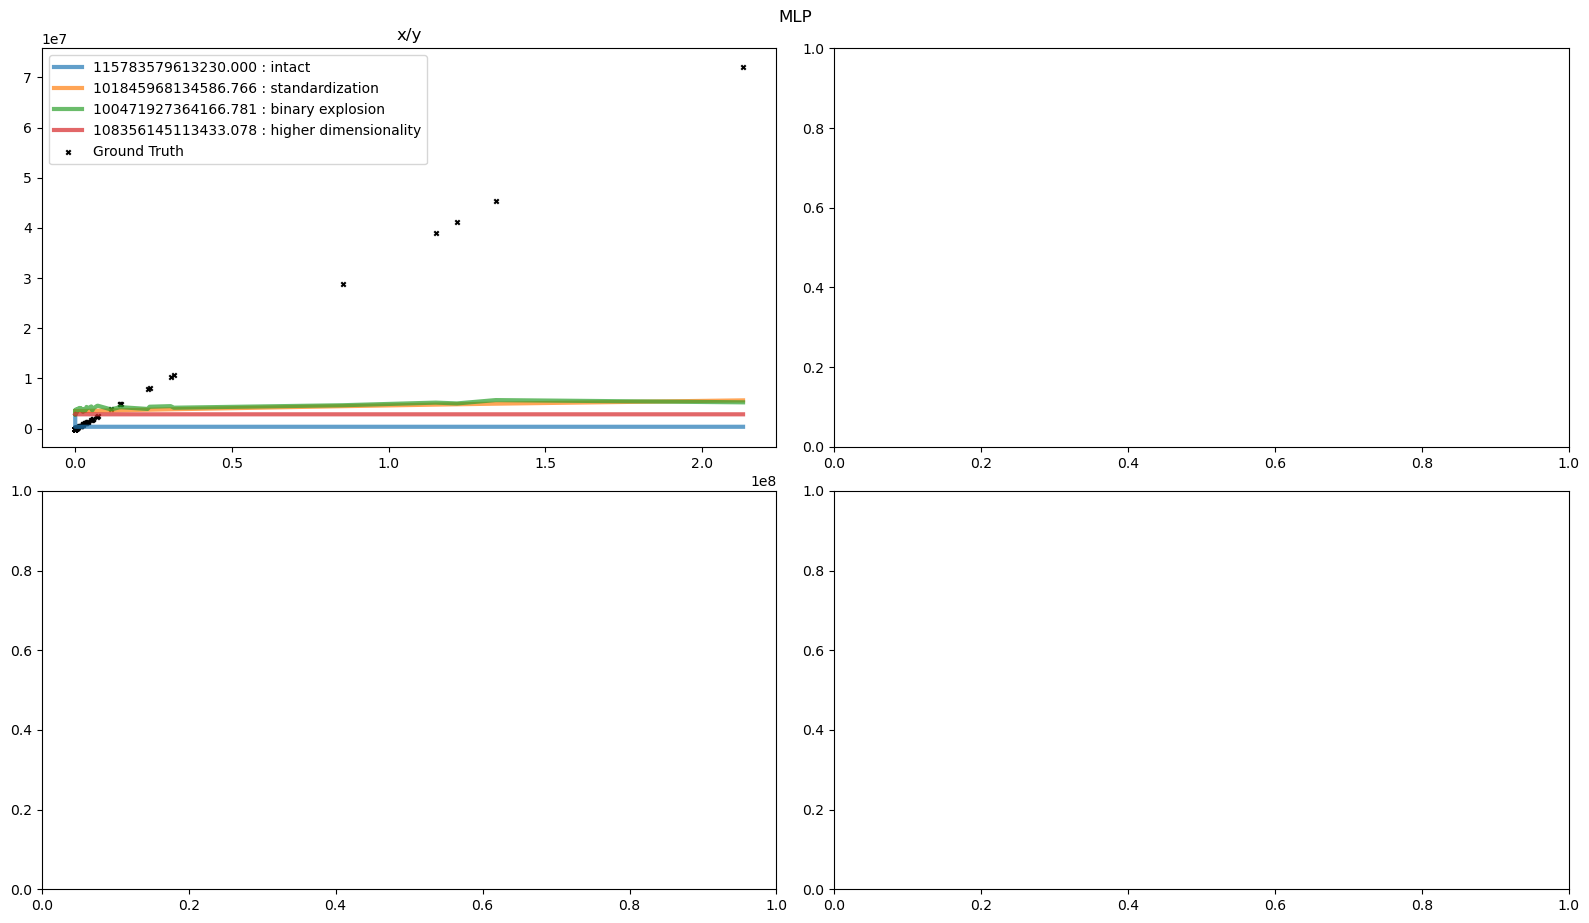

In [5]:
x_array = ['x']
y_array = ['y']

fig, ax = plt.subplots(2, 2, figsize=(16, 9))
fig.tight_layout()
transform_layer = IntegerBaseEncoder()
activation = activation=keras.activations.sigmoid
tranformations = {'intact': lambda x: x,
                  'standardization': standard,
                  'binary explosion': lambda x: transform_layer(x).squeeze(1),
                  'higher dimensionality': lambda x, n=3: np.power(x, np.arange(1, n))}


for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):
        cur_x, cur_y = eval(x_name), eval(y_name)
        

        for name_transformation, func_transformation in tranformations.items():
            transformed_x = func_transformation(cur_x)
            try:
                model = MLP(transformed_x.shape[1], 1, 512, depth=4, activation=activation)
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
                model.fit(transformed_x, cur_y, epochs=500, verbose=0)
                y_hat = model.predict(transformed_x)
                score = mse(y_hat, cur_y)
                print(name_transformation, score)
                ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')
            except:
                print(name_transformation, 'NANS')


        ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('MLP', y=1.02)
plt.show()

In [9]:
seed = 123
tf.random.set_seed(seed)
n_samples = 1000
n_features = 1
mean = 10
std = 2

In [10]:
standard = lambda x:(x - x.mean())/x.std()

In [37]:
for dist_name in ['normal', 'lognormal', 'exponential']:
    gen = generator.DataGenerator(mean=mean, std=std, dist=dist_name, is_int=True)
    x, y = gen.generate(n_features=n_features, n_samples=n_samples)
    x = np.ravel(x)
    order = np.argsort(x).reshape(-1, 1)
    x, y = x[order], y[order]
    exec(f'x_{dist_name}=x\ny_{dist_name}=y')

In [38]:
x_array = ['x_normal', 'x_exponential', 'x_lognormal']
y_array = ['y_normal','y_exponential', 'y_lognormal']

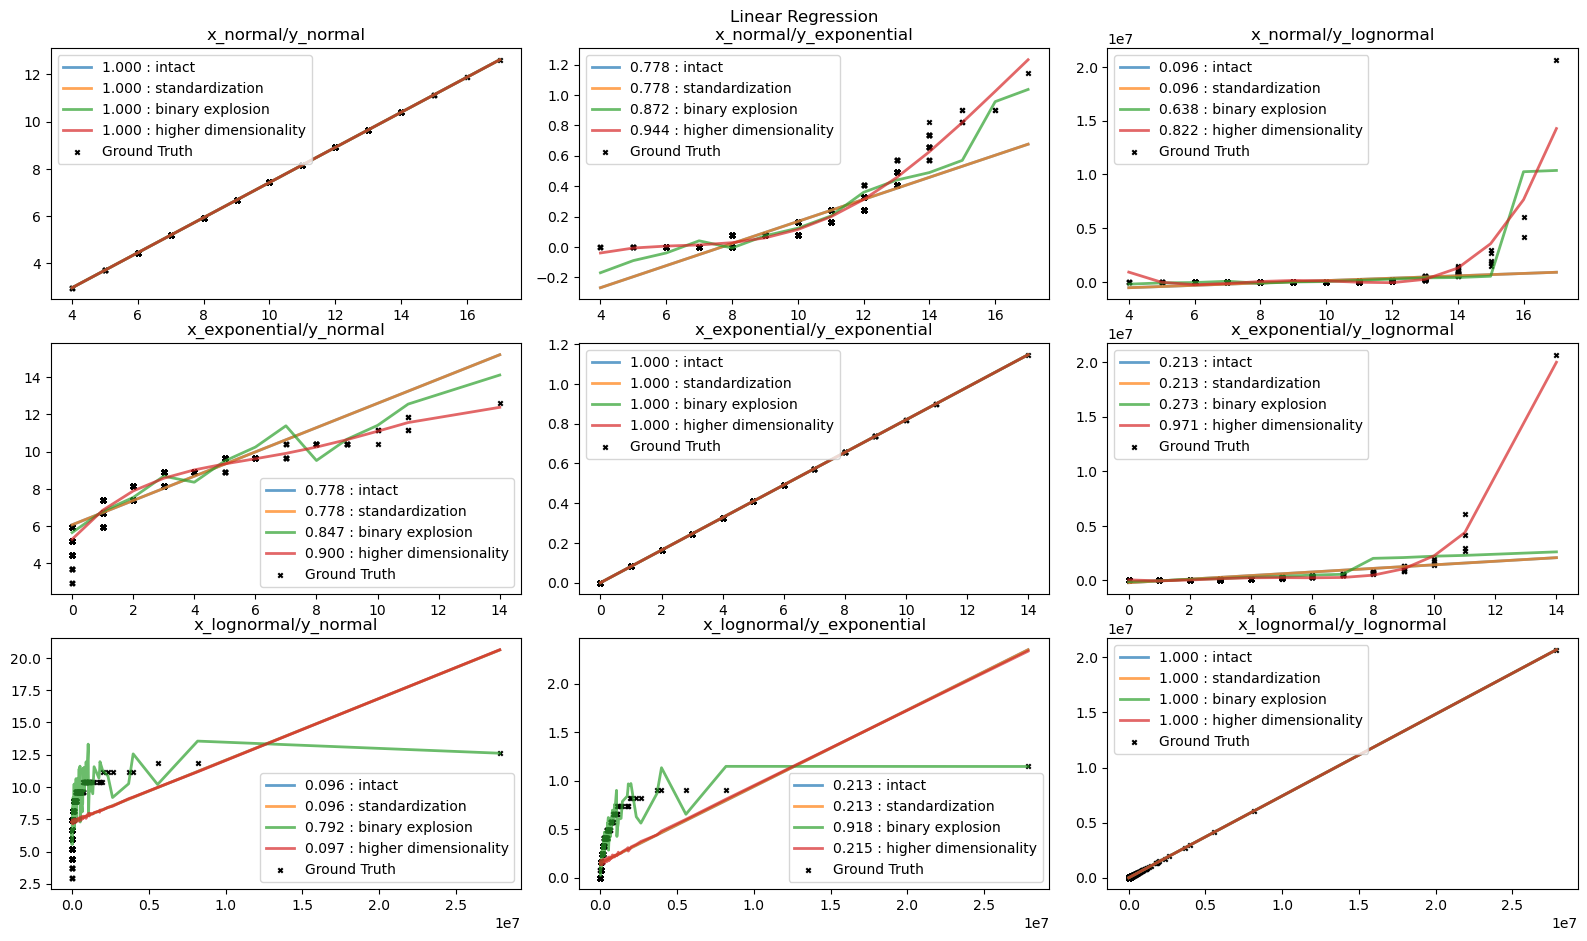

In [39]:
transform_layer = IntegerBaseEncoder()


fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
fig.tight_layout()

tranformations = {'intact': lambda x: x,
                  'standardization': standard,
                  'binary explosion': lambda x: transform_layer(x).squeeze(1),
                  'higher dimensionality': lambda x, n=5: np.power(x, np.arange(1, n))}
baseline = LinearRegression

for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):
        cur_x, cur_y = eval(x_name), eval(y_name)

        for name_transformation, func_transformation in tranformations.items():
            transformed_x = func_transformation(cur_x)
            
            model = baseline()
            model.fit(transformed_x, cur_y)
                        
            y_hat = model.predict(transformed_x)
            score = model.score(transformed_x, cur_y)
            ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=2, label=f'{score:0.3f} : {name_transformation}')


        ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('Linear Regression', y=1.02)
plt.show()

In [2]:
class _MLPBlock(keras.layers.Layer):
    def __init__(self, width, droprate=0, regularization=keras.regularizers.L1L2(0), **kwargs):
        super(_MLPBlock, self).__init__()
        self.dense = layers.Dense(width, 
                                  kernel_initializer=initializers.RandomNormal(seed=seed),
                                  kernel_regularizer=regularization, **kwargs)
#         self.activation = layers.ReLU()
#         self.drop = layers.Dropout(droprate)
#         self.bn = layers.BatchNormalization()
        
    def call(self, inputs, **kwargs):
        x = self.dense(inputs)
#         x = self.activation(x)
#         x = self.drop(x)
#         x = self.bn(x)
        return x

# implement policy network
class MLP(keras.Model):
    def __init__(self, input_dim, output_dim, hidden_dim=64, depth=1, **kwargs):
        super().__init__()
        self.depth = depth
        self.hidden_0 = _MLPBlock(hidden_dim, input_shape=(input_dim,), **kwargs)

        for i in range(1, depth):
            setattr(self, f'hidden_{i}', _MLPBlock(hidden_dim))
        self.out = _MLPBlock(output_dim)

    
    def call(self, inputs):
        x = inputs
        for i in range(self.depth):
            x = getattr(self, f'hidden_{i}')(x)
        x = self.out(x)
        return x

In [3]:
seed_list = [1,2,3,4,5]
dist_list = ['normal', 'lognormal', 'exponential']
n_samples = 1000
n_features = 1
mean = 10
std = 2
epochs = 20

In [4]:
standard = lambda x:(x - x.mean())/x.std()

In [7]:
x_array = []
y_array = []
for dist_name in dist_list:
    exec(f'x_{dist_name}={{}}\ny_{dist_name}={{}}')
    x_array.append(f'x_{dist_name}')
    y_array.append(f'y_{dist_name}')
    for seed in seed_list:
        tf.random.set_seed(seed)
        gen = generator.DataGenerator(mean=mean, std=std, dist=dist_name, is_int=True)
        x, y = gen.generate(n_features=n_features, n_samples=n_samples)
        x = np.ravel(x)
        order = np.argsort(x).reshape(-1, 1)
        x, y = x[order], y[order]
        exec(f'x_{dist_name}[seed]=x\ny_{dist_name}[seed]=y')

[5.57018852e+00 1.53375447e+00 9.64766145e-01 3.98177564e-01
 8.92512798e-02 1.33824684e-02 4.54883557e-03 4.20663180e-03
 4.13587457e-03 4.09076409e-03 4.24042530e-03 3.83686367e-03
 4.14830493e-03 4.64322697e-03 5.06771123e-03 4.15920280e-03
 4.76064766e-03 7.34611927e-03 6.86821993e-03 6.03887485e-03]
32/32 [==============================] - 0s 2ms/step
intact 0.00358613217120892
[1.20179133e+01 3.13561332e+00 2.19460928e+00 1.07565981e+00
 3.74451488e-01 7.62406774e-02 1.17875729e-02 7.90237612e-03
 7.84024084e-03 7.60718226e-03 7.95156998e-03 7.25430949e-03
 7.81989470e-03 8.80988594e-03 9.30496631e-03 7.98202539e-03
 8.84499261e-03 1.36150457e-02 1.28188538e-02 1.08004939e-02]
32/32 [==============================] - 0s 2ms/step
intact 0.0035813576885701756
[2.09619317e+01 4.81485987e+00 3.43246472e+00 1.84356540e+00
 7.66058922e-01 2.16120470e-01 3.70248891e-02 1.39459560e-02
 1.30148199e-02 1.25880002e-02 1.34181583e-02 1.23733380e-02
 1.28642069e-02 1.39370332e-02 1.51892267e-

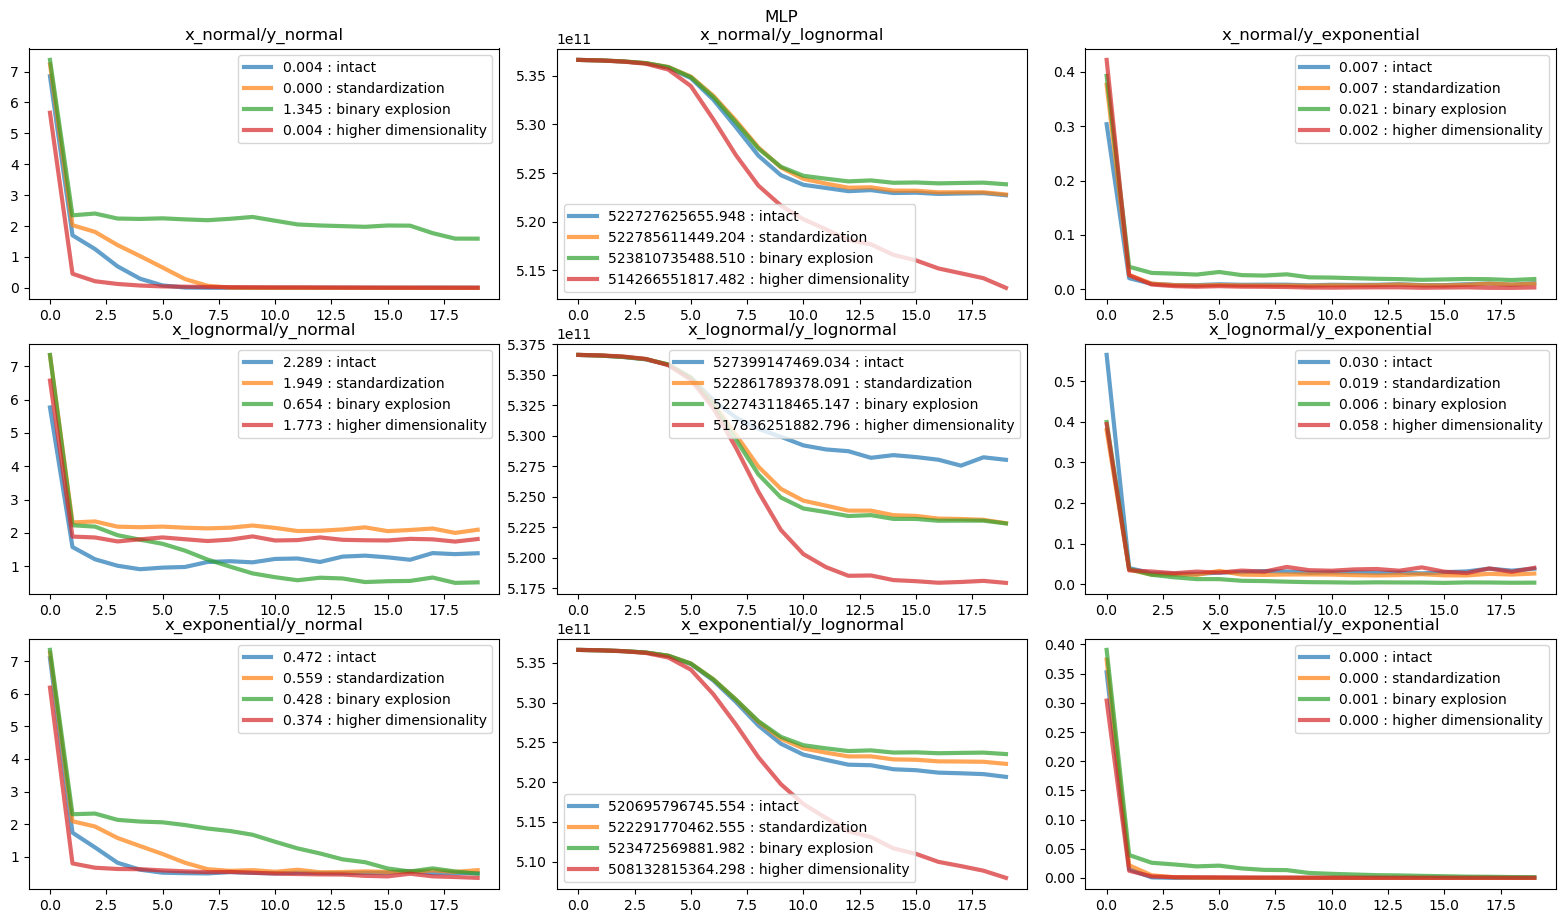

In [50]:
fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
fig.tight_layout()
transform_layer = IntegerBaseEncoder()
activation = activation=keras.activations.sigmoid
tranformations = {'intact': lambda x: x,
                  'standardization': standard,
                  'binary explosion': lambda x: transform_layer(x).squeeze(1),
                  'higher dimensionality': lambda x, n=3: np.power(x, np.arange(1, n))}


for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):            
        for name_transformation, func_transformation in tranformations.items():
            
            history = np.zeros(epochs)
            for seed in seed_list:
                cur_x, cur_y = eval(x_name+'[seed]'), eval(y_name+'[seed]')
                transformed_x = func_transformation(cur_x)
                try:
                    model = MLP(transformed_x.shape[1], 1, 512, depth=4, activation=activation)
                    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
                    batch = model.fit(transformed_x, cur_y, epochs=epochs, verbose=0)
                    # print(batch.history['loss'])
                    history += np.array(batch.history['loss'])
                    # print(history)
                    y_hat = model.predict(transformed_x)
                    score = mse(y_hat, cur_y)
                    print(name_transformation, score)
                    # ax[idx, idy].plot(history.history['loss'], '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')
                except:
                    print(name_transformation, 'NANS')

            history = history/len(seed_list)
            print(f'final: {history}')
            ax[idx, idy].plot(history, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')

        # ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('MLP', y=1.02)
plt.show()

In [4]:
seed_list = [1,2,3,4,5]
dist_list = ['normal', 'lognormal', 'exponential']
n_samples = 1000
n_features = 1
mean = 1
std = 0.6
epochs = 20

In [5]:
standard = lambda x:(x - x.mean())/x.std()

In [6]:
x_array = []
y_array = []
for dist_name in dist_list:
    exec(f'x_{dist_name}={{}}\ny_{dist_name}={{}}')
    x_array.append(f'x_{dist_name}')
    y_array.append(f'y_{dist_name}')
    for seed in seed_list:
        tf.random.set_seed(seed)
        gen = generator.DataGenerator(mean=mean, std=std, dist=dist_name, is_int=False)
        x, y = gen.generate(n_features=n_features, n_samples=n_samples)
        x = np.ravel(x)
        order = np.argsort(x).reshape(-1, 1)
        x, y = x[order], y[order]
        exec(f'x_{dist_name}[seed]=x\ny_{dist_name}[seed]=y')

32/32 [==============================] - 0s 2ms/step
intact 0.1328510117054329
32/32 [==============================] - 0s 2ms/step
intact 0.1478494220333707
32/32 [==============================] - 0s 2ms/step
intact 0.14241737346383912
32/32 [==============================] - 0s 2ms/step
intact 0.14926366200804417
32/32 [==============================] - 0s 2ms/step
intact 0.14394524638353953
final: [0.29592375 0.19887089 0.1957815  0.19385342 0.19227114 0.1908462
 0.18871712 0.18745006 0.18697775 0.18344692 0.18013402 0.17753751
 0.17464179 0.17158888 0.16825965 0.16486683 0.16061441 0.15800818
 0.15141158 0.14642214]
32/32 [==============================] - 0s 2ms/step
binary explosion 0.17158805051372555
32/32 [==============================] - 0s 1ms/step
binary explosion 0.17388687814704132
32/32 [==============================] - 0s 2ms/step
binary explosion 0.17574111932627406
32/32 [==============================] - 0s 2ms/step
binary explosion 0.17421333745789205
32/32 [====

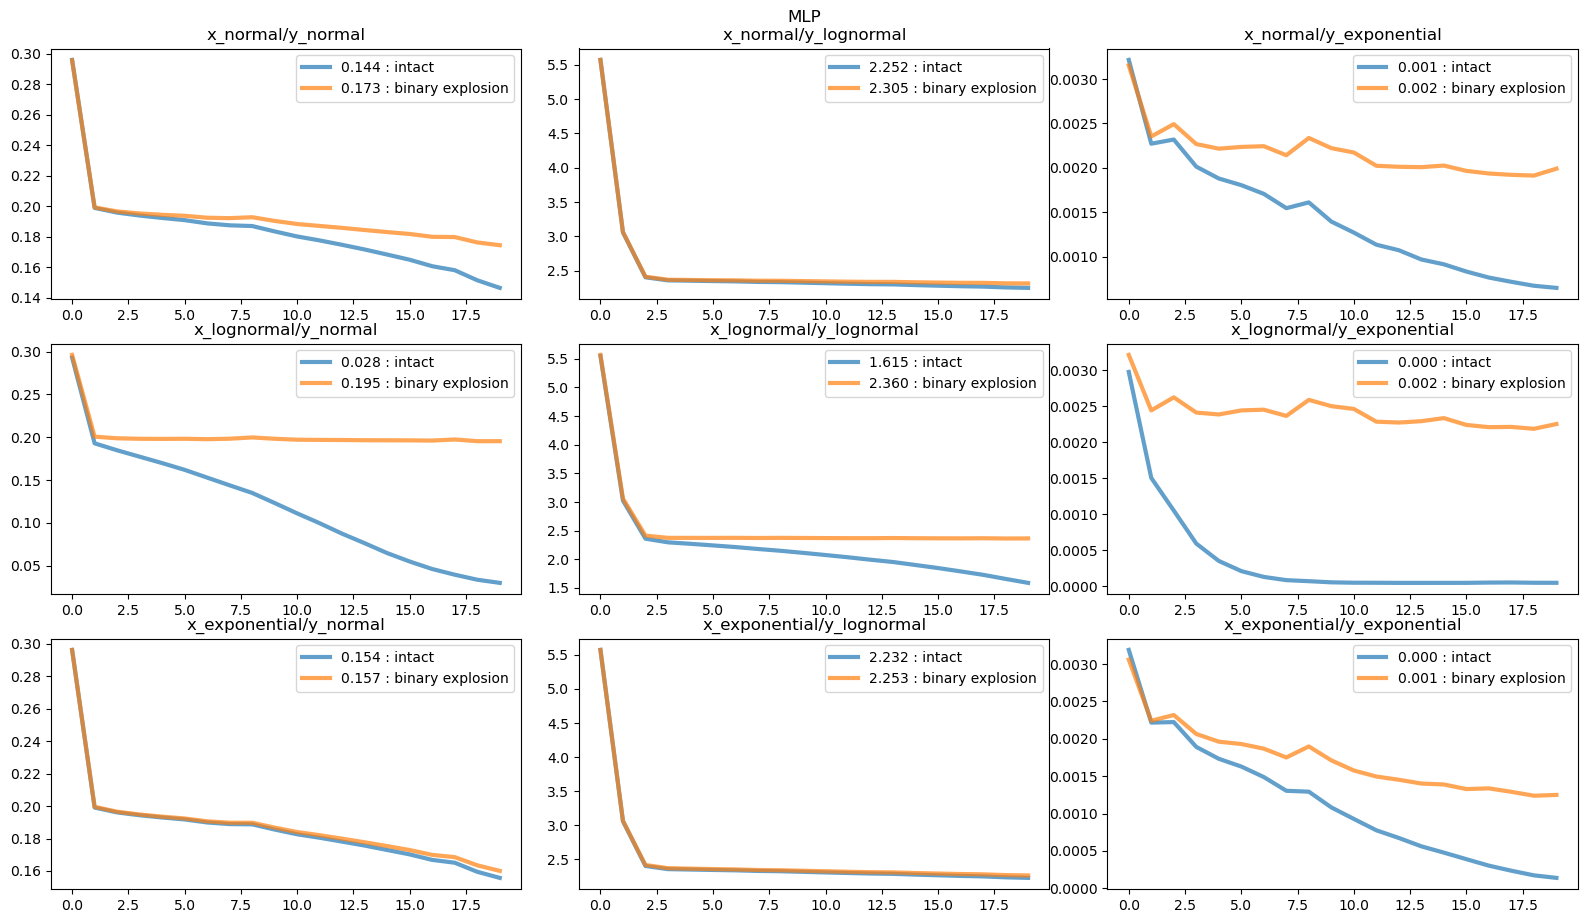

In [10]:
fig, ax = plt.subplots(len(x_array), len(y_array), figsize=(16, 9))
fig.tight_layout()
transform_layer = FloatBaseEncoder(base=10, encode_sign=True, column_width=32)
transform_layer_only_integers = FloatBaseEncoder(base=16, encode_sign=True, column_width=32, only_integers=True)
activation = activation=keras.activations.sigmoid
tranformations = {  'intact': lambda x: x,
                    # 'standardization': standard,
                    'binary explosion': lambda x: transform_layer(x).squeeze(1)
                    # 'binary explosion o/i': lambda x: transform_layer_only_integers(x).squeeze(1),
                    # 'higher dimensionality': lambda x, n=5: np.power(x, np.arange(1, n))
                    }

for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):            
        for name_transformation, func_transformation in tranformations.items():
            
            history = np.zeros(epochs)
            for seed in seed_list:
                cur_x, cur_y = eval(x_name+'[seed]'), eval(y_name+'[seed]')
                transformed_x = func_transformation(cur_x)
                try:
                    model = MLP(transformed_x.shape[1], 1, 128, depth=2, activation=activation)
                    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
                    batch = model.fit(transformed_x, cur_y, epochs=epochs, verbose=0)
                    # print(batch.history['loss'])
                    history += np.array(batch.history['loss'])
                    # print(history)
                    y_hat = model.predict(transformed_x)
                    score = mse(y_hat, cur_y)
                    print(name_transformation, score)
                    # ax[idx, idy].plot(history.history['loss'], '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')
                except:
                    print(name_transformation, 'NANS')

            history = history/len(seed_list)
            print(f'final: {history}')
            ax[idx, idy].plot(history, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')

        # ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('MLP', y=1.02)
plt.show()